In [4]:
import numpy as np
from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    get_tuids_containing,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)

import matplotlib.pyplot as plt
import itertools
from matplotlib.colors import Normalize, LinearSegmentedColormap

In [5]:
from qce_utils.support_classes.xarray_bootstrap import XarrayBootstrap
from qce_utils.addon_quantify.object_factories.factory_state_acquisition import (
    QNDPiOptimizationFactory,
    QNDPiStateClassifierFactory,
    AcquisitionType,
)
from qce_utils.control_interfaces.datastorage_control.analysis_factories.factory_state_classification import (
    QNDPiStateClassifierAnalysis,
)
from qce_utils.qed_modeling.intrf_state_classification import (
    IQNDPiStateClassifierContainer,
    RepeatedQNDPiStateClassifierContainer,
    IMultiQubitQNDPiStateClassifierContainer,
    MultiQubitQNDPiStateClassifierContainer,
)

In [3]:
fmin_low = np.array([6.9759,7.0771,7.3878,7.5066,7.6011,7.8229])*1e9
fmin_high = np.array([6.9979,7.0971,7.4093,7.5266,7.6186,7.8429])*1e9

In [4]:
fmin_total = np.concatenate((fmin_low,fmin_high))

In [5]:
#Frequency range for sweep
LO_min = np.max(fmin_total)-500*1e6
LO_max = np.min(fmin_total)+500*1e6

print(rf"LO in [{LO_min:g}, {LO_max:g}]")

LO in [7.3429e+09, 7.4759e+09]


In [6]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


['Z4' 'X4' 'D8' 'D9' 'D6']
[7.56194707 7.4978816  7.34179993 7.29955454 7.71369834]


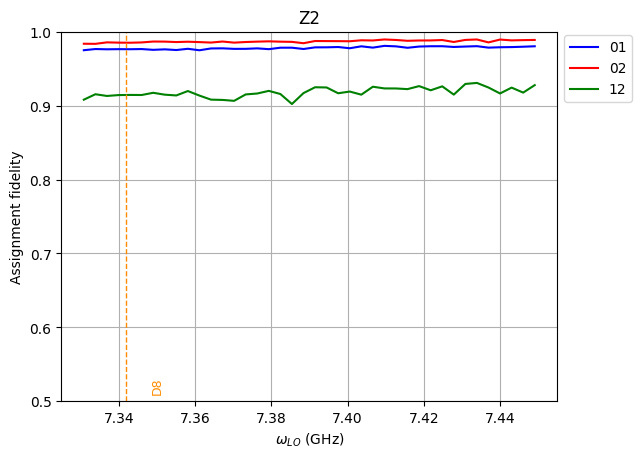

['Z2' 'X4' 'D8' 'D9' 'D6']
[7.56194707 7.45319889 7.29711722 7.25487183 7.66901563]


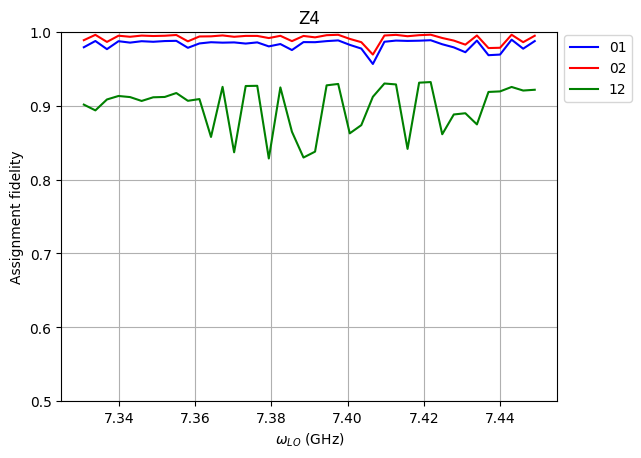

['Z2' 'Z4' 'D8' 'D9' 'D6']
[7.4978816  7.45319889 7.23305175 7.19080636 7.60495016]


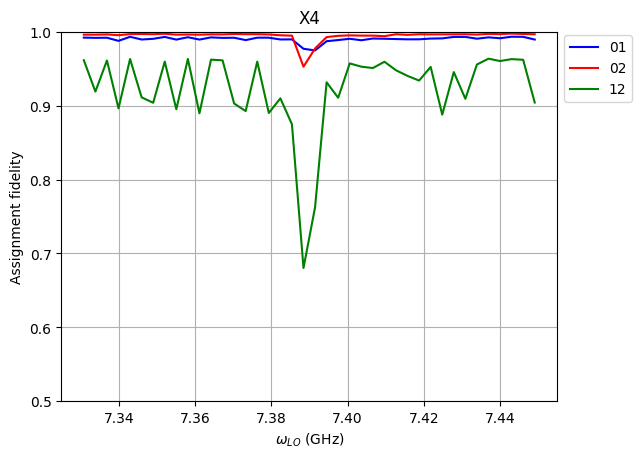

['Z2' 'Z4' 'X4' 'D9' 'D6']
[7.34179993 7.29711722 7.23305175 7.03472469 7.44886849]


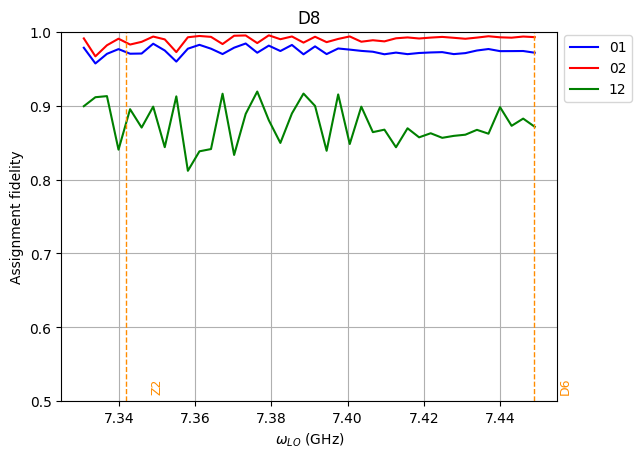

['Z2' 'Z4' 'X4' 'D8' 'D6']
[7.29955454 7.25487183 7.19080636 7.03472469 7.4066231 ]


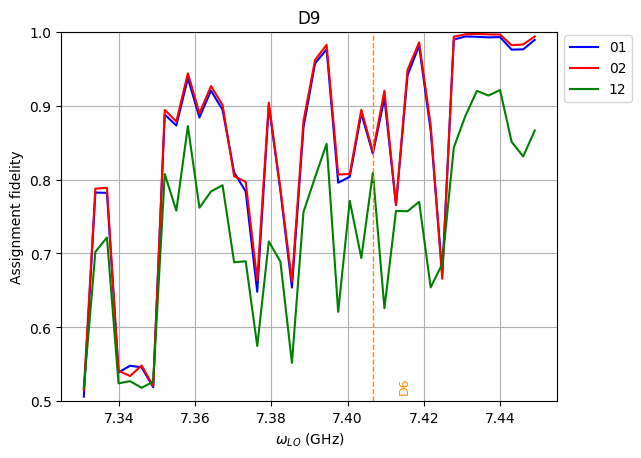

['Z2' 'Z4' 'X4' 'D8' 'D9']
[7.71369834 7.66901563 7.60495016 7.44886849 7.4066231 ]


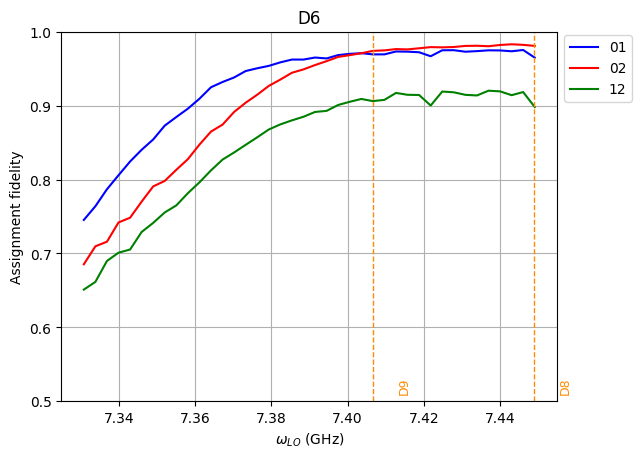

In [50]:
# tuid = get_latest_tuid(contains="Test")
qubits = ['Z2', 'Z4', 'X4', 'D8', 'D9', 'D6']
rfs = np.array([7606629775.117803, 7517264362.158905, 7389133418.719978, 7076970082.864434, 6992479294.91219, 7820766903.557389])*1e-9 
num_sweep = len(get_tuids_containing(f"SSRO QND Z2", "20250429"))

lo_frequencies = np.linspace(7330766903.557389, 7482479294.91219, 51)[:num_sweep]*1e-9

for qubit_index in range(len(qubits)):
    qubit = qubits[qubit_index]
    tuids = get_tuids_containing(f"SSRO QND {qubit}", "20250429")

    #Calculate the lo frequency that lies in between two qubit frequencies
    rf = rfs[qubit_index]
    qubit_label = np.delete(qubits, qubit_index)
    tmp_rfs = np.delete(rfs, qubit_index)
    lo_freq_middle = (tmp_rfs + rf)/2

    print(qubit_label)
    print(lo_freq_middle)
    
    Fid_01 = []
    Fid_02 = []
    Fid_12 = []
    
    for tuid in tuids:
        dataset = load_dataset(tuid)
    
        dataset = XarrayBootstrap(data=dataset)
        data_object: RepeatedQNDPiStateClassifierContainer = QNDPiStateClassifierFactory(
            acquisition_type=AcquisitionType.THREE_STATE,
            use_heralded_post_selection=True,
            qnd_repetitions=10,
        ).construct(dataset)
        
        boundaries = data_object.host_state_boundaries
        
        F_01 = data_object.get_fidelity(boundary=boundaries[0])
        F_02 = data_object.get_fidelity(boundary=boundaries[1])
        F_12 = data_object.get_fidelity(boundary=boundaries[2])
    
        Fid_01.append(F_01)
        Fid_02.append(F_02)
        Fid_12.append(F_12)
    
    plt.plot(lo_frequencies, Fid_01, label = "01", c = "blue")
    plt.plot(lo_frequencies, Fid_02, label="02", c = "red")
    plt.plot(lo_frequencies, Fid_12, label="12", c = "green")
    plt.grid()
    plt.ylabel("Assignment fidelity")
    plt.xlabel(r"$\omega_{LO}$ (GHz)")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01))
    
    plt.ylim(0.5,1)
    
    # Plot vlines and add labels at the bottom of each line
    ymin, ymax = plt.ylim()  # Get current y-axis limits
    for freq, label in zip(lo_freq_middle, qubit_label):
        if freq >= np.min(lo_frequencies) and freq <= np.max(lo_frequencies):
            plt.axvline(x=freq, color='darkorange', linestyle='--', linewidth=1)
            plt.text(freq + 0.01, ymin + 0.02 * (ymax - ymin), label,
                     rotation=90, verticalalignment='bottom', horizontalalignment='right',
                     fontsize=9, color='darkorange')
    
    plt.title(qubit)
    plt.savefig(f"Figures/Ass_fid_vs_LO_{qubit}.png", bbox_inches='tight')
    plt.show()

#For plotting figure 
# analysis_factory = QNDPiStateClassifierAnalysis()
# analysis_factory 

# analysis_factory.construct_figure(data_object)
# plt.show()

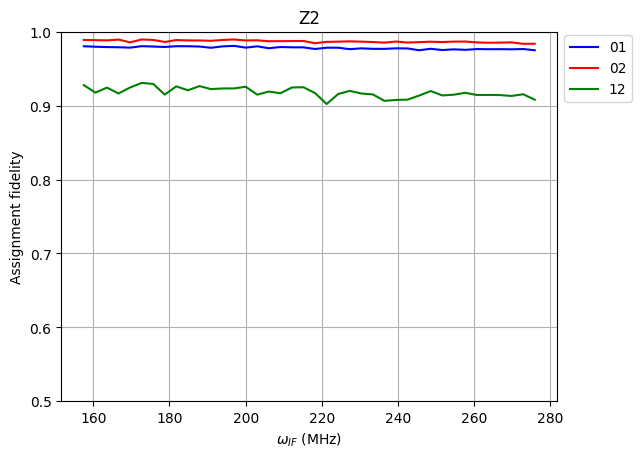

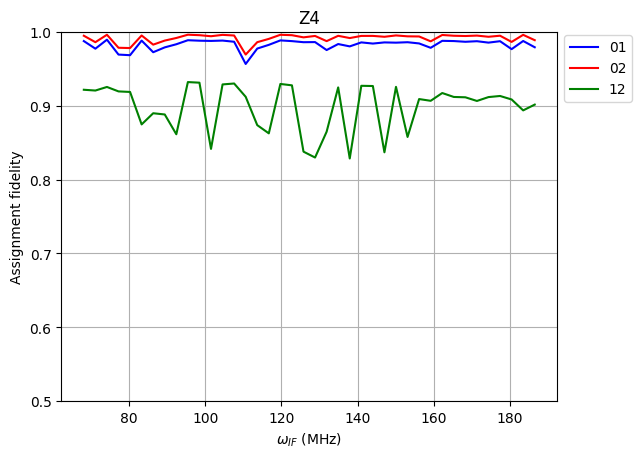

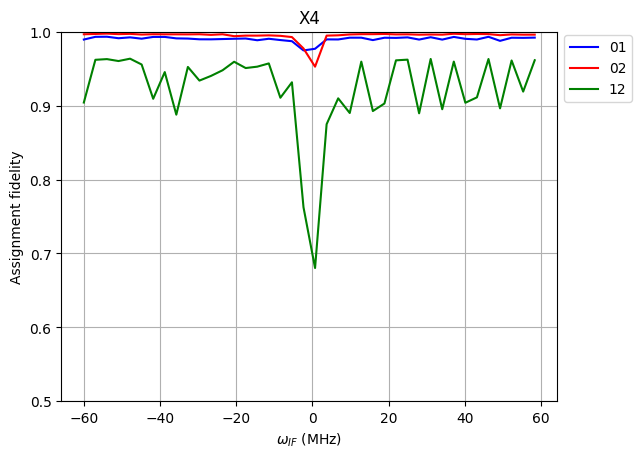

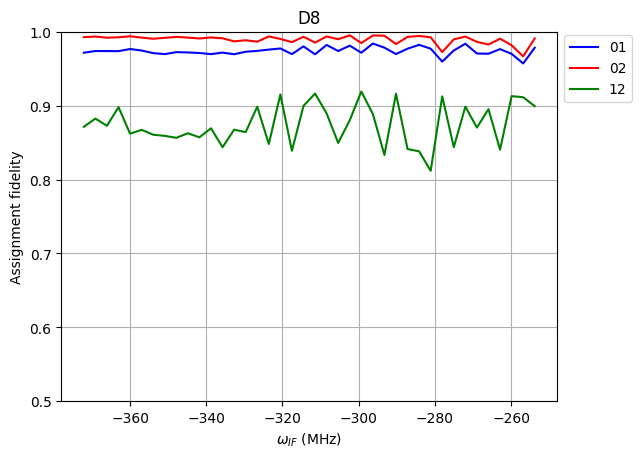

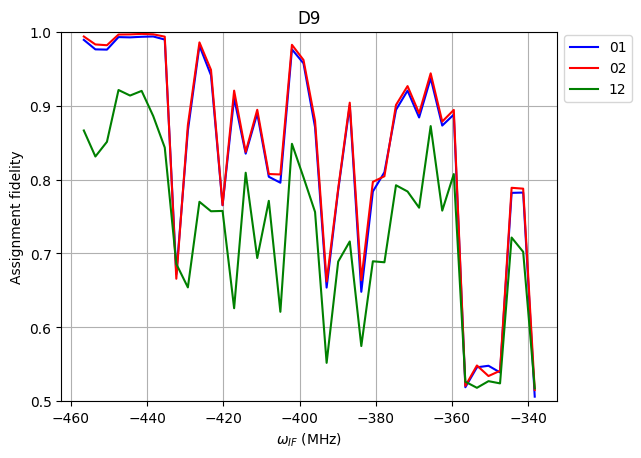

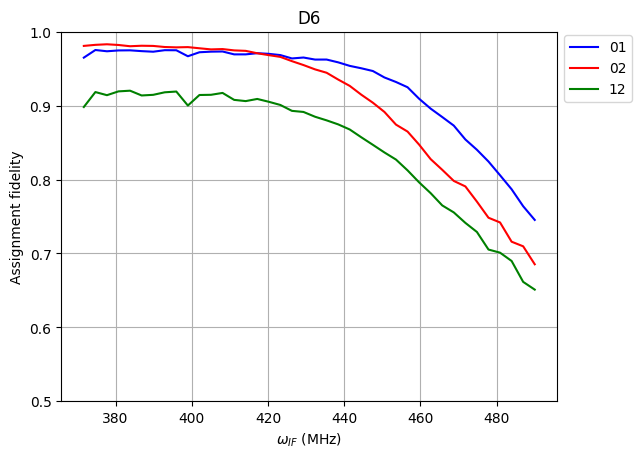

In [28]:
# tuid = get_latest_tuid(contains="Test")
qubits = ['Z2', 'Z4', 'X4', 'D8', 'D9', 'D6']
rfs = np.array([7606629775.117803, 7517264362.158905, 7389133418.719978, 7076970082.864434, 6992479294.91219, 7820766903.557389]) 
num_sweep = len(get_tuids_containing(f"SSRO QND Z2", "20250429"))

lo_frequencies = np.linspace(7330766903.557389, 7482479294.91219, 51)[:num_sweep]

for qubit_index in range(len(qubits)):
    qubit = qubits[qubit_index]
    tuids = get_tuids_containing(f"SSRO QND {qubit}", "20250429")

    #Calculate the lo frequency that lies in between two qubit frequencies
    rf = rfs[qubit_index]
    
    Fid_01 = []
    Fid_02 = []
    Fid_12 = []
    
    for tuid in tuids:
        dataset = load_dataset(tuid)
    
        dataset = XarrayBootstrap(data=dataset)
        data_object: RepeatedQNDPiStateClassifierContainer = QNDPiStateClassifierFactory(
            acquisition_type=AcquisitionType.THREE_STATE,
            use_heralded_post_selection=True,
            qnd_repetitions=10,
        ).construct(dataset)
        
        boundaries = data_object.host_state_boundaries
        
        F_01 = data_object.get_fidelity(boundary=boundaries[0])
        F_02 = data_object.get_fidelity(boundary=boundaries[1])
        F_12 = data_object.get_fidelity(boundary=boundaries[2])
    
        Fid_01.append(F_01)
        Fid_02.append(F_02)
        Fid_12.append(F_12)
    
    plt.plot((rf-lo_frequencies)*1e-6, Fid_01, label = "01", c = "blue")
    plt.plot((rf-lo_frequencies)*1e-6, Fid_02, label="02", c = "red")
    plt.plot((rf-lo_frequencies)*1e-6, Fid_12, label="12", c = "green")
    plt.grid()
    plt.ylabel("Assignment fidelity")
    plt.xlabel(r"$\omega_{IF}$ (MHz)")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01))
    
    plt.ylim(0.5,1)
    plt.title(qubit)
    plt.savefig(f"Figures/Ass_fid_vs_IF_{qubit}.png", bbox_inches='tight')
    plt.show()


['Z4' 'X4' 'D8' 'D9' 'D6']


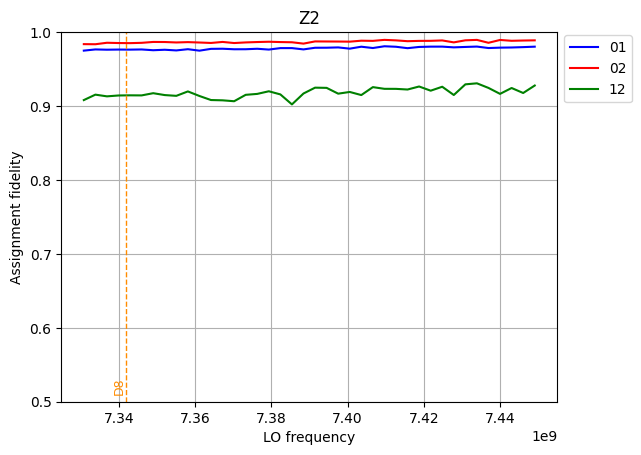

In [40]:
# qubits = ['Z2', 'Z4', 'X4', 'D8', 'D9', 'D6']
# rfs = np.array([7606629775.117803, 7517264362.158905, 7389133418.719978, 7076970082.864434, 6992479294.91219, 7820766903.557389]) 
# qubit_index = 0
# rf = rfs[qubit_index]

# qubit_label = np.delete(qubits, qubit_index)
# tmp_rfs = np.delete(rfs, qubit_index)
# lo_freq_middel = (tmp_rfs + rf)/2


# plt.plot(lo_frequencies, Fid_01, label = "01", c = "blue")
# plt.plot(lo_frequencies, Fid_02, label="02", c = "red")
# plt.plot(lo_frequencies, Fid_12, label="12", c = "green")
# plt.grid()
# # plt.savefig(f"Figures/Ass_fid_vs_LO_{qubit}.pdf"
# plt.ylabel("Assignment fidelity")
# plt.xlabel("LO frequency")
# plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01))

# plt.ylim(0.5,1)

# frequencies = [7.34*1e9, 7.4*1e9]
# labels = ['X1', 'X2']
# # Plot vlines and add labels near the bottom right of each line
# ymin, ymax = plt.ylim()  # Get current y-axis limits
# for freq, label in zip(lo_freq_middel, qubit_label):
#     if freq >= np.min(lo_frequencies) and freq <= np.max(lo_frequencies):
#         plt.axvline(x=freq, color='darkorange', linestyle='--', linewidth=1)
#         plt.text(freq + 0.01, ymin + 0.02 * (ymax - ymin), label,
#                  rotation=90, verticalalignment='bottom', horizontalalignment='right',
#                  fontsize=9, color='darkorange')

# plt.title(qubits[0])
# plt.show()

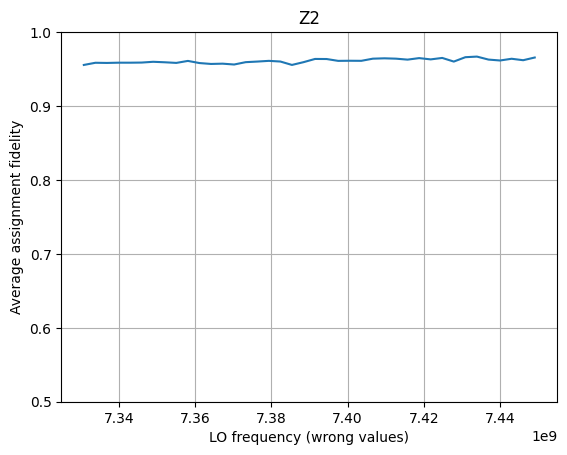

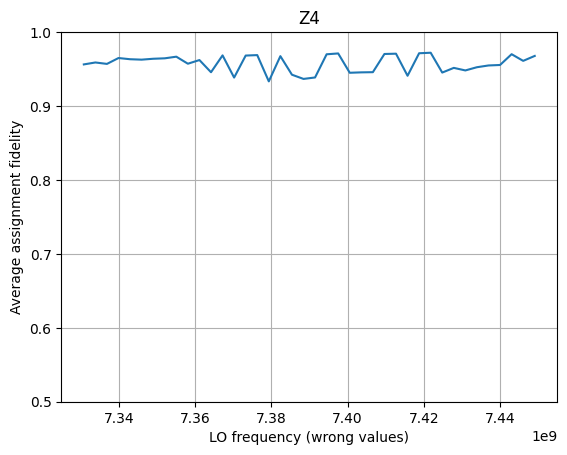

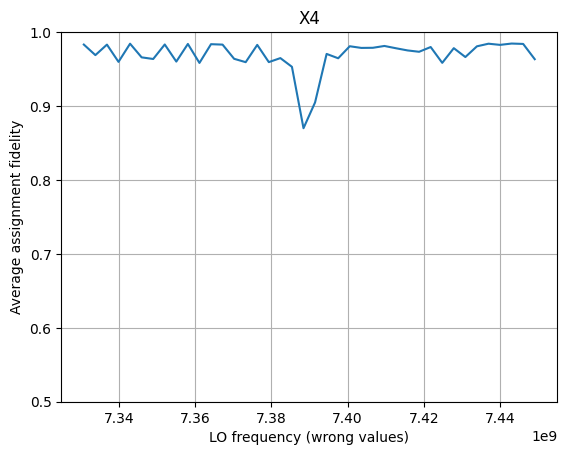

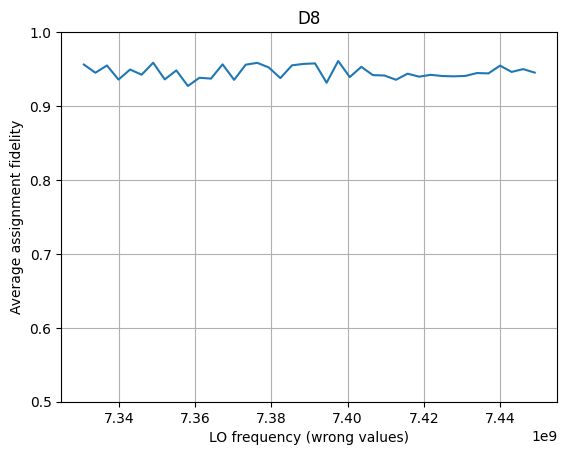

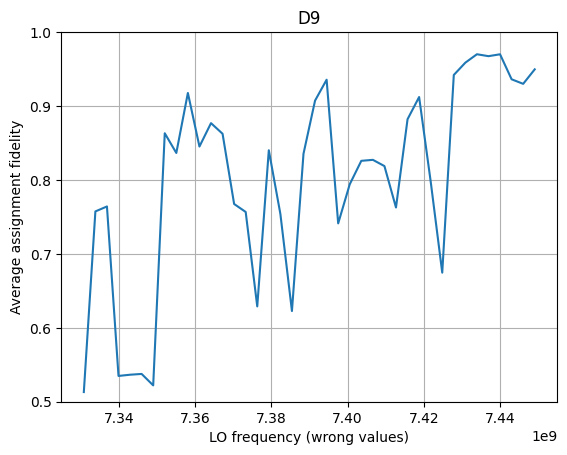

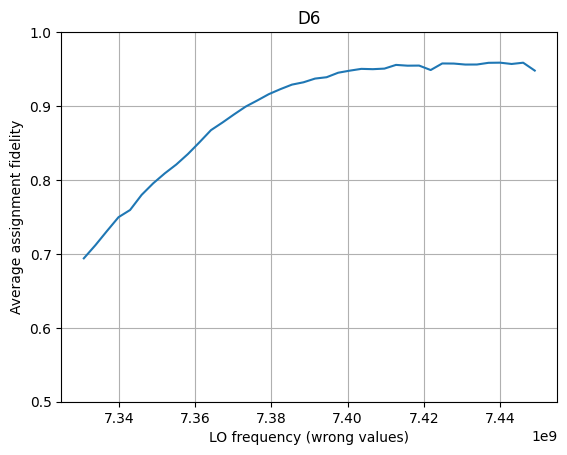

In [111]:
# # tuid = get_latest_tuid(contains="Test")
# qubits = ['Z2', 'Z4', 'X4', 'D8', 'D9', 'D6']

# for qubit in qubits:
#     tuids = get_tuids_containing(f"SSRO QND {qubit}", "20250429")
    
#     Fid_av = []
    
#     for tuid in tuids:
#         dataset = load_dataset(tuid)
    
#         dataset = XarrayBootstrap(data=dataset)
#         data_object: RepeatedQNDPiStateClassifierContainer = QNDPiStateClassifierFactory(
#             acquisition_type=AcquisitionType.THREE_STATE,
#             use_heralded_post_selection=True,
#             qnd_repetitions=10,
#         ).construct(dataset)
        
#         boundaries = data_object.host_state_boundaries
        
#         F_av = data_object.average_fidelity
#         Fid_av.append(F_av)
    
#     plt.plot(lo_frequencies, Fid_av)
#     plt.grid()
#     plt.ylabel("Average assignment fidelity")
#     plt.xlabel("LO frequency (wrong values)")
#     # plt.legend()
#     plt.ylim(0.5,1)
#     plt.title(qubit)
#     plt.show()

#For plotting figure 
# analysis_factory = QNDPiStateClassifierAnalysis()
# analysis_factory 

# analysis_factory.construct_figure(data_object)
# plt.show()

In [7]:
tuids = get_tuids_containing("Test", "20250429")

tuid = tuids[0]

dataset = load_dataset(tuid)
qubits = ['Z2', 'Z4', 'X4', 'D8', 'D9', 'D6']

meas_outcomes = []
for i in range(len(qubits)):
    tuids = get_tuids_containing(f"SSRO QND {qubits[i]}", "20250429")
    
    calibration_dataset = load_dataset(tuids[0])
    
    calibration_dataset = XarrayBootstrap(data=calibration_dataset)
    calibration_data_object: RepeatedQNDPiStateClassifierContainer = QNDPiStateClassifierFactory(
        acquisition_type=AcquisitionType.THREE_STATE,
        use_heralded_post_selection=True,
        qnd_repetitions=10,
    ).construct(calibration_dataset)
    classifier = calibration_data_object.assignment_classifier.state_acquisition.classification_boundaries
    
    shots = dataset[f'y{2*i}'].values + 1j*dataset[f'y{2*i+1}'].values
    states = classifier.get_binary_predictions(shots)
    meas_outcomes.append(states)



In [10]:
def measured_to_counts(dataset, meas_outcomes):
    elements = dataset.attrs["elements"]
    num_elements = len(elements) #Number of qubits
    
    prepStates = dataset.attrs["states"]
    N_states = len(prepStates)

    num_reps = dataset.attrs["number_of_repetitions"]
    
    stacked = np.column_stack([meas_outcomes[i] for i in range(num_elements)]).astype(int)
    stacked_strings = np.array(["".join(row.astype(str)) for row in stacked])
   
    # Reshape into groups of `reps`
    reshaped_strings = stacked_strings.reshape(N_states, num_reps)
    
    # Count occurences
    result = {prepStates[i]: dict(zip(*np.unique(reshaped_strings[i], return_counts=True))) for i in range(N_states)}
    
    return result

def compute_transition_matrix(data, j, k):  
    """
    Computes the transition matrix A(j, k) for two-qubit errors based on measurement outcomes.

    Parameters:
    - data: Dictionary where keys are input bitstrings and values are dictionaries.
      Each inner dictionary has measured output bitstrings as keys and their counts as values.
    - j, k: The two qubits of interest.

    Returns:
    - A: The 4x4 transition matrix A(j, k), normalized column-wise.
    """
    num_states = 4  # 2-qubit system has 4 possible states: "00", "01", "10", "11"
    A = np.zeros((num_states, num_states))  # Transition matrix
    state_to_index = {"00": 0, "01": 1, "10": 2, "11": 3}
    input_state_counts = np.zeros(num_states)  # Column-wise normalization counts
    
    for x, outcomes in data.items():
        input_state = x[j] + x[k]  # Extract 2-qubit input state
        input_index = state_to_index[input_state]  

        # Mask to remove j and k, preserving other qubits
        mask = [i != j and i != k for i in range(len(x))]
        remaining_input_state = "".join([char for char, include in zip(x, mask) if include])

        for y, count in outcomes.items():
            measured_state = y[j] + y[k]  # Extract 2-qubit measured state
            remaining_output_state = "".join([char for char, include in zip(y, mask) if include])
            
            if remaining_input_state == remaining_output_state:
                output_index = state_to_index[measured_state]
                A[output_index, input_index] += count
                input_state_counts[input_index] += count  # Track input occurrences
    
    # Normalize each column
    for col in range(num_states):
        if input_state_counts[col] > 0:
            A[:, col] /= input_state_counts[col]

    return A

def plot_2qb_transition_matrix(matrix, qubits):
    # Define the labels
    labels = ["00", "01", "10", "11"]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Mask for diagonal elements (True for diagonal, False for off-diagonal)
    diag_mask = np.zeros_like(matrix, dtype=bool)
    np.fill_diagonal(diag_mask, True)  # Diagonal elements are True

    # Create a custom colormap for diagonal elements (shades of dark blue)
    blues_dark = LinearSegmentedColormap.from_list("blues_dark", ["#1f3a64", "#4b79a1"])
    
    # Plot the off-diagonal elements with a red colormap
    cax_off_diag = ax.matshow(np.ma.masked_array(matrix, mask=diag_mask), cmap="Reds", 
                              vmin=0.0, vmax=0.05, alpha=0.6)
    
    # Plot the diagonal elements with the custom dark blue colormap
    cax_diag = ax.matshow(np.ma.masked_array(matrix, mask=~diag_mask), cmap=blues_dark, 
                          vmin=0.9, vmax=1.0, alpha=1)
    
    # Add colorbars for both
    fig.colorbar(cax_diag, ax=ax, shrink=0.8, label="Diagonal elements")
    fig.colorbar(cax_off_diag, ax=ax, shrink=0.8, label="Off-diagonal elements")
    
    # Set tick labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # Annotate the values inside the cells
    for i in range(len(labels)):
        for j in range(len(labels)):
            # Set text color to white if it's on the diagonal, else black
            text_color = "white" if i == j else "black"
            ax.text(j, i, f"{matrix[i, j]:.4f}", ha="center", va="center", color=text_color)

    # Set title
    plt.title(f"Transition matrix qubits {' '.join(qubit for qubit in qubits)}")

    # Move the x-ticks to the lower x-axis (if not already there)
    ax.xaxis.set_ticks_position('bottom')

    # Set x and y axis labels
    ax.set_xlabel("Prepared state")
    ax.set_ylabel("Assigned state")

    
    
    # Display the plot
    plt.show()

    return None

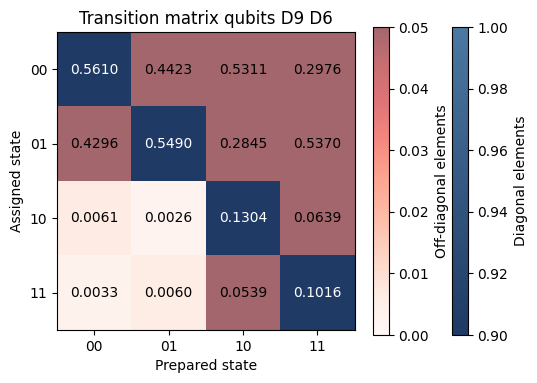

In [42]:
qubits = dataset.attrs["elements"]
N_qubits = len(qubits)

arr = np.arange(N_qubits)  # [0, 1, 2]
combinations = list(itertools.combinations(arr, 2))

counts = measured_to_counts(dataset, meas_outcomes)

for i in combinations:
    if qubits[i[0]] == "D9" and qubits[i[1]] == "D6":
        tmp = compute_transition_matrix(counts,i[0],i[1])
        plot_2qb_transition_matrix(tmp, [qubits[i[0]],qubits[i[1]]])

Code below is for the evolution of the transition matrix of D9 and D6 when sweeping LO

In [18]:
num_sweep = len(get_tuids_containing(f"SSRO QND Z2", "20250429"))
lo_frequencies = np.linspace(7330766903.557389, 7482479294.91219, 51)[:num_sweep]

step = 1 #Should be integer and devidable by number of sweeps (in this case 40)

tuids = get_tuids_containing("Test", "20250429")

# save_objective = []
indices = np.arange(len(tuids))[::step]

trans_matrix_data = {}

# indices = [indices[-1]]
for index in indices:
    print("LO frequency: ", lo_frequencies[index])
    tuid = tuids[index]
    dataset = load_dataset(tuid)
    qubits = ['Z2', 'Z4', 'X4', 'D8', 'D9', 'D6']
    
    meas_outcomes = []
    
    for i in range(len(qubits)):
        calibration_tuids = get_tuids_containing(f"SSRO QND {qubits[i]}", "20250429")
        
        calibration_dataset = load_dataset(calibration_tuids[index])
        
        calibration_dataset = XarrayBootstrap(data=calibration_dataset)
        calibration_data_object: RepeatedQNDPiStateClassifierContainer = QNDPiStateClassifierFactory(
            acquisition_type=AcquisitionType.THREE_STATE,
            use_heralded_post_selection=True,
            qnd_repetitions=10,
        ).construct(calibration_dataset)
        classifier = calibration_data_object.assignment_classifier.state_acquisition.classification_boundaries
        
        shots = dataset[f'y{2*i}'].values + 1j*dataset[f'y{2*i+1}'].values
        states = classifier.get_binary_predictions(shots)
        meas_outcomes.append(states)

    qubits = dataset.attrs["elements"]
    N_qubits = len(qubits)
    
    arr = np.arange(N_qubits)  # [0, 1, 2]
    combinations = list(itertools.combinations(arr, 2))
    
    counts = measured_to_counts(dataset, meas_outcomes)

    # objective = 0 
    # off_diag_elements = []
    # diag_elements = []
    
    for i in combinations:
        # if qubits[i[0]] == "D9" and qubits[i[1]] == "D6":
    
        tmp = compute_transition_matrix(counts,i[0],i[1])
        diag = np.trace(tmp)
        off_diag = np.sum(tmp) - diag
        
        qubit_comb = qubits[i[0]] + qubits[i[1]]
        if qubit_comb not in trans_matrix_data:
            trans_matrix_data[qubit_comb] = {"off_diagonal": [], "diagonal": []}

        trans_matrix_data[qubit_comb]["diagonal"].append(diag)
        trans_matrix_data[qubit_comb]["off_diagonal"].append(off_diag)
    
        # print(qubits[i[0]]+qubits[i[1]])
        # objective += np.sum(tmp) - np.trace(tmp)
        # plot_2qb_transition_matrix(tmp, [qubits[i[0]],qubits[i[1]]])

    # save_objective.append(objective)
    # print("Objective: ", objective)
    

LO frequency:  7330766903.557389
LO frequency:  7333801151.384485
LO frequency:  7336835399.211581
LO frequency:  7339869647.038677
LO frequency:  7342903894.865773
LO frequency:  7345938142.692869
LO frequency:  7348972390.519965
LO frequency:  7352006638.347061
LO frequency:  7355040886.174157
LO frequency:  7358075134.001253
LO frequency:  7361109381.828349
LO frequency:  7364143629.655445
LO frequency:  7367177877.482541
LO frequency:  7370212125.309638
LO frequency:  7373246373.136734
LO frequency:  7376280620.96383
LO frequency:  7379314868.790926
LO frequency:  7382349116.618022
LO frequency:  7385383364.445118
LO frequency:  7388417612.272214
LO frequency:  7391451860.09931
LO frequency:  7394486107.926406
LO frequency:  7397520355.753502
LO frequency:  7400554603.580598
LO frequency:  7403588851.407694
LO frequency:  7406623099.23479
LO frequency:  7409657347.061886
LO frequency:  7412691594.888982
LO frequency:  7415725842.716078
LO frequency:  7418760090.543174
LO frequency:

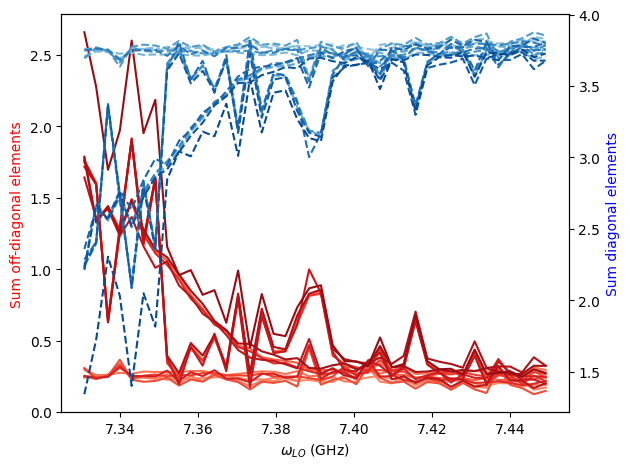

In [27]:
# Create figure and axis
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Generate color maps
num_keys = len(trans_matrix_data)
red_colors = plt.cm.Reds(np.linspace(0.4, 0.9, num_keys))
blue_colors = plt.cm.Blues(np.linspace(0.4, 0.9, num_keys))

# Iterate and plot
for i, key in enumerate(trans_matrix_data):
    # Off-diagonal (left axis, red)
    ax1.plot(lo_frequencies * 1e-9,
             trans_matrix_data[key]["off_diagonal"],
             color=red_colors[i],
             label=f"{key} (off-diag)")

    # Diagonal (right axis, blue)
    ax2.plot(lo_frequencies * 1e-9,
             trans_matrix_data[key]["diagonal"],
             color=blue_colors[i],
             linestyle='--',
             label=f"{key} (diag)")

# Axis labels
ax1.set_xlabel(r"$\omega_{LO}$ (GHz)")
ax1.set_ylabel("Sum off-diagonal elements", color="red")
ax2.set_ylabel("Sum diagonal elements", color="blue")

# # Combine legends
# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()

    

In [8]:
# num_sweep = len(get_tuids_containing(f"SSRO QND Z2", "20250429"))
# lo_frequencies = np.linspace(7330766903.557389, 7482479294.91219, 51)[:num_sweep]

# step = 1 #Should be integer and devidable by number of sweeps (in this case 40)

# tuids = get_tuids_containing("Test", "20250429")

# # print(save_objective)

# # indices = np.arange(len(tuids))[::step]
# print(np.argmin(save_objective))
# # indices = [np.argmin(save_objective)]
# indices = [-1]
# for index in indices:
#     print("LO frequency: ", lo_frequencies[index])
#     tuid = tuids[index]
#     dataset = load_dataset(tuid)
#     qubits = ['Z2', 'Z4', 'X4', 'D8', 'D9', 'D6']
    
#     meas_outcomes = []
#     save_objective = []
    
#     for i in range(len(qubits)):
#         calibration_tuids = get_tuids_containing(f"SSRO QND {qubits[i]}", "20250429")
        
#         calibration_dataset = load_dataset(calibration_tuids[index])
        
#         calibration_dataset = XarrayBootstrap(data=calibration_dataset)
#         calibration_data_object: RepeatedQNDPiStateClassifierContainer = QNDPiStateClassifierFactory(
#             acquisition_type=AcquisitionType.THREE_STATE,
#             use_heralded_post_selection=True,
#             qnd_repetitions=10,
#         ).construct(calibration_dataset)
#         classifier = calibration_data_object.assignment_classifier.state_acquisition.classification_boundaries
        
#         shots = dataset[f'y{2*i}'].values + 1j*dataset[f'y{2*i+1}'].values
#         states = classifier.get_binary_predictions(shots)
#         meas_outcomes.append(states)

#     qubits = dataset.attrs["elements"]
#     N_qubits = len(qubits)
    
#     arr = np.arange(N_qubits)  # [0, 1, 2]
#     combinations = list(itertools.combinations(arr, 2))
    
#     counts = measured_to_counts(dataset, meas_outcomes)

#     objective = 0 
    
#     for i in combinations:
#         # if qubits[i[0]] == "D9" and qubits[i[1]] == "D6":
#         tmp = compute_transition_matrix(counts,i[0],i[1])
#         # objective += np.sum(tmp) - np.trace(tmp)
#         plot_2qb_transition_matrix(tmp, [qubits[i[0]],qubits[i[1]]])

NameError: name 'save_objective' is not defined

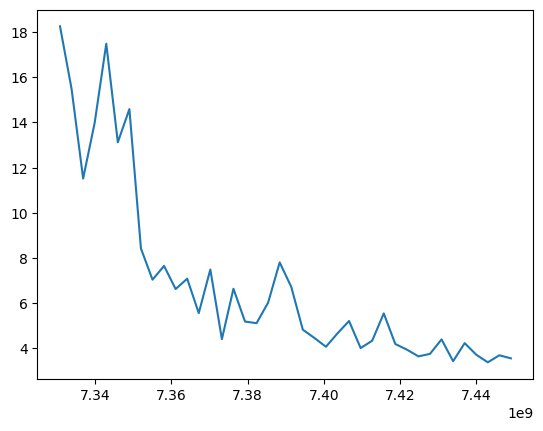

In [113]:
plt.plot(lo_frequencies,save_objective)
plt.show()